## Summary

The following report/notebook aims towards building a machine learning model that predicts whether a given menu item is an entree or not by utilizing the features associated with that item.

During this journey, a series of intermediate steps were undertaken while mentioning the rationale behind those steps.

The report/notebook is divided into the following sections:<br>
1) Data exploration<br> 
2) Data cleaning<br>
3) Feature Extraction<br>
4) Model Selection<br>
5) Choice of metrics for model evaluation and their significance<br>
6) Other methods/techniques that could be implemented<br>
7) Additional information that would have been useful<br>

## 1) Data Exploration

In [2]:
## Importing the necessary libraries
import pandas as pd
import re
import numpy as np
import string
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [3]:
## Reading the train and test data
train = pd.read_csv('menu_item_train.csv')
test = pd.read_csv('menu_item_test.csv')

### Data size

In [4]:
print('There are {} train records and {} test records'.format(train.shape[0], test.shape[0]))

There are 2491 train records and 276 test records


In [5]:
print('The sample train data looks like this:')
train.head()

The sample train data looks like this:


,name,description,price,menu_section_name,category,is_entree
0,Grande Caesar Salad,NaN,9.95,Salad,Salad,0
1,Medium 16 oz. Green Mayo Smoothie,NaN,4.75,Smoothies,Smoothies,0
2,Iced Tea,"Brewed fresh daily, our Iced Tea pairs seamles...",0.00,Beverages,Beverages,0
3,Specialty Pretzel,Jalapeno cheese and Dutch almond.,3.75,A la Carte,A la Carte,0
4,Broccoli Bites with Cheese,Twelve pieces.,5.99,Side Orders,Side Orders,0


In [6]:
print('The sample test data looks like this:')
test.head()

The sample test data looks like this:


,name,description,price,menu_section_name,category,is_entree
0,Homemade Brownie,"Topped with vanilla ice cream, caramel and can...",5.95,Sweets,Sweets,0
1,Spicy Fries,NaN,0.00,Side Orders,Side Orders,0
2,Pastrami Sub,Pastrami and provolone cheese served fully inv...,0.00,Hot Subs,Hot Subs,1
3,Coquito Float,NaN,10.00,Desserts,Desserts,0
4,Hummus and Vegetables,NaN,10.00,Starters,Starters,0


### Overall distribution of target variable 'is_entree' in train and test data

From the plots we below, we see that there are about 9% records with is_entree=1 in train data and 4.7% such records in test data. Hence the data isn't evenly distributed b/w is_entree=1 and is_entree=0 and would be something to keep in mind when choosing the evaluation metric during modeling phase of this exercise.

In [7]:
print('In the overall train data, {}% records are entrees'.format(round(100.0*len(train[train['is_entree']==1])/train.shape[0], 2)))

In the overall train data, 9.03% records are entrees


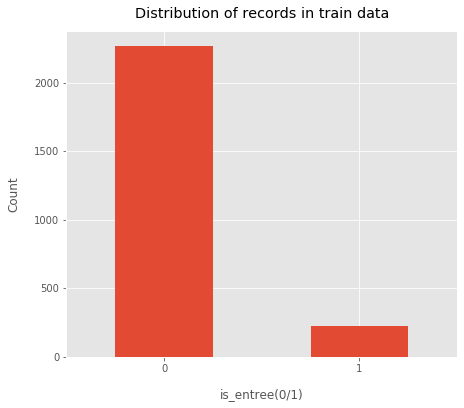

In [8]:
train['is_entree'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("is_entree(0/1)", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records in train data", y=1.02);

In [9]:
print('In the overall test data, {}% records are entrees'.format(round(100.0*len(test[test['is_entree']==1])/test.shape[0], 2)))

In the overall test data, 4.71% records are entrees


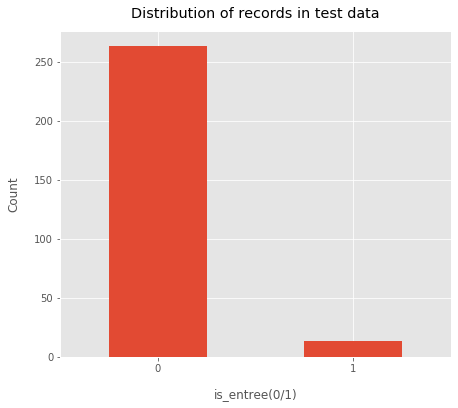

In [10]:
test['is_entree'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("is_entree(0/1)", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records in test data", y=1.02);

### Distribution of target variable 'is_entree' in train and test data across 'category' feature

From the below plots depicting the distribution of various categories across variable 'is_entree' in the train and test data, there are few interesting insights:<br>

1) The distribution of categries isn't even and some of the categories are dominant compared to others.<br>

2) Although the categrories like 'breakfast', 'meals' and 'entrees' are categorized as is_entree=1 but at the same time categories like 'breakfast meals', 'breakfast entrees' are categorized as is_entree=0. This leads us to think that we might want to use additional features like 'name', 'description' to help the ML model better learn and distinguish b/w such scenarios.<br>

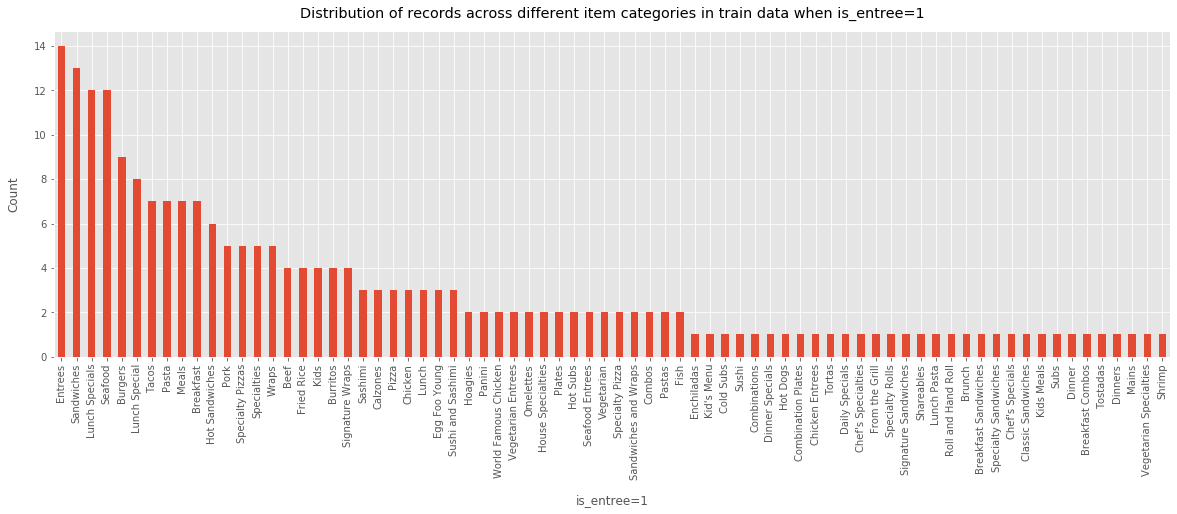

In [11]:
train[train['is_entree']==1]['category'].value_counts().plot(kind='bar', figsize=(20, 6), rot=90)
plt.xlabel("is_entree=1", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records across different item categories in train data when is_entree=1", y=1.02);

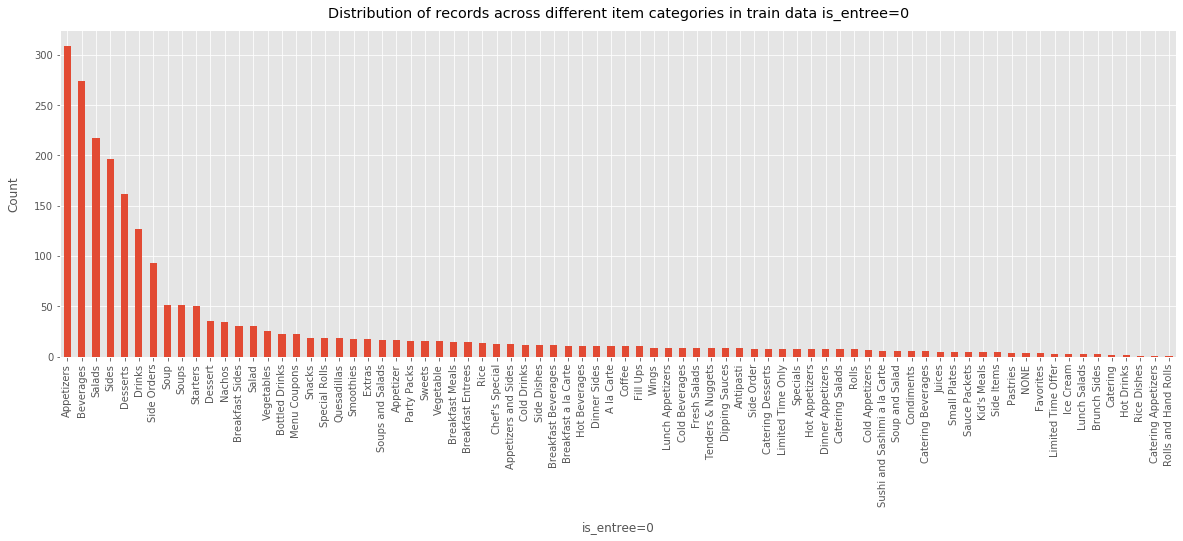

In [12]:
train[train['is_entree']==0]['category'].value_counts().plot(kind='bar', figsize=(20, 6), rot=90)
plt.xlabel("is_entree=0", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records across different item categories in train data is_entree=0", y=1.02);

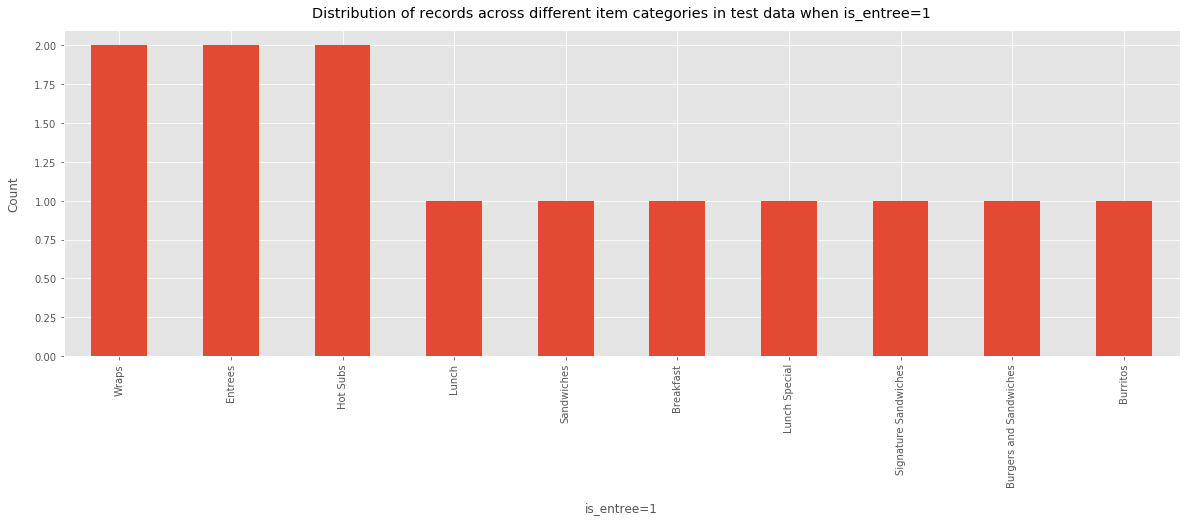

In [13]:
test[test['is_entree']==1]['category'].value_counts().plot(kind='bar', figsize=(20, 6), rot=90)
plt.xlabel("is_entree=1", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records across different item categories in test data when is_entree=1", y=1.02);

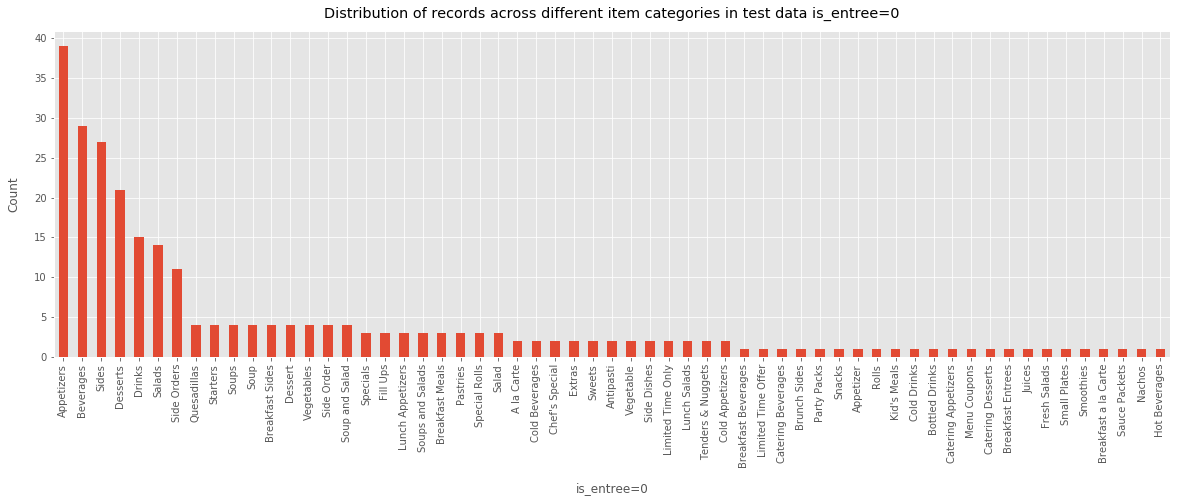

In [14]:
test[test['is_entree']==0]['category'].value_counts().plot(kind='bar', figsize=(20, 6), rot=90)
plt.xlabel("is_entree=0", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of records across different item categories in test data is_entree=0", y=1.02);

### Distribution of 'price' feature across train and test data

The histogram below depicts the distribution of 'price' values across train and test data. Some of the key take-aways:<br>

1) Item prices are not normally distributed and are right skewed. This feature would need to be rescaled in the later section. Feature scaling is often needed when using ML algorthims which use Gradient Descent as an optimization technique. Having features on a similar scale can help the gradient descent converge more quickly towards the minima.


Text(0.5, 1.02, 'Distribution of item prices in the train data')

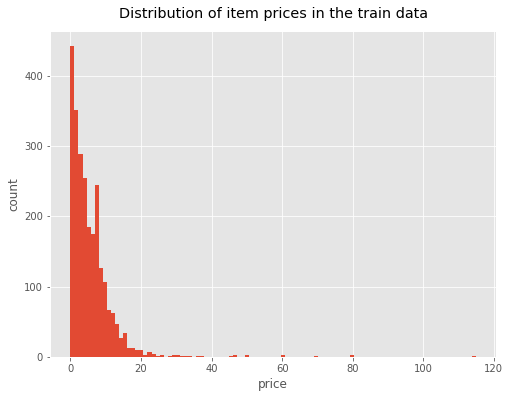

In [15]:
fig = plt.figure(figsize=(8,6))
plt.hist(train['price'], bins=100)
plt.xlabel('price')
plt.ylabel('count')
plt.title("Distribution of item prices in the train data", y=1.02)

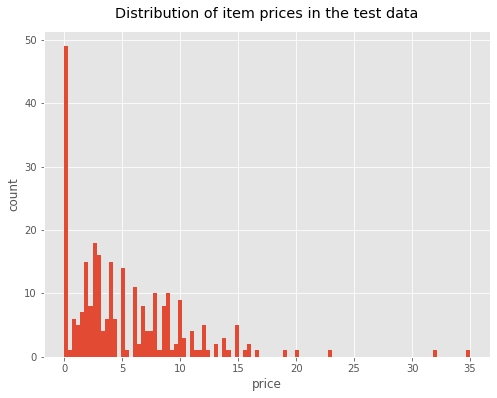

In [16]:
fig = plt.figure(figsize=(8,6))
plt.hist(test['price'], bins=100)
plt.xlabel('price')
plt.ylabel('count')
plt.title("Distribution of item prices in the test data", y=1.02);
plt.show()

### Distribution of length (no. of words) of the 'description' feature across train and test data

The distribution below depicts how the long the 'description' field is across different item records. This information is valuable in choosing suitable model which works well with long text sequences.<br>

We see that for a lot of items, the description field is empty (length=0) 

In [17]:
train['description_length'] = train['description'].str.split().str.len()
train['description_length'].fillna(0, inplace=True)

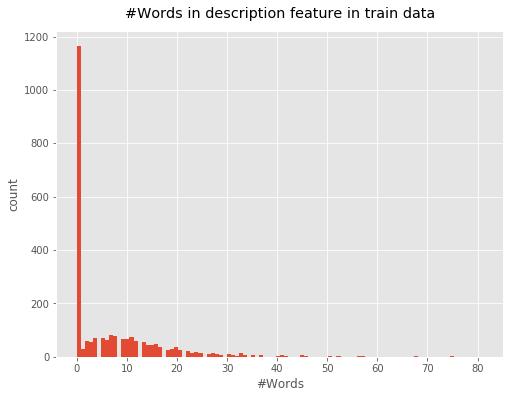

In [18]:
fig = plt.figure(figsize=(8,6))
plt.hist(train['description_length'], bins=100)
plt.xlabel('#Words')
plt.ylabel('count')
plt.title("#Words in description feature in train data", y=1.02);
plt.show()

del train['description_length']

In [19]:
test['description_length'] = test['description'].str.split().str.len()
test['description_length'].fillna(0, inplace=True)

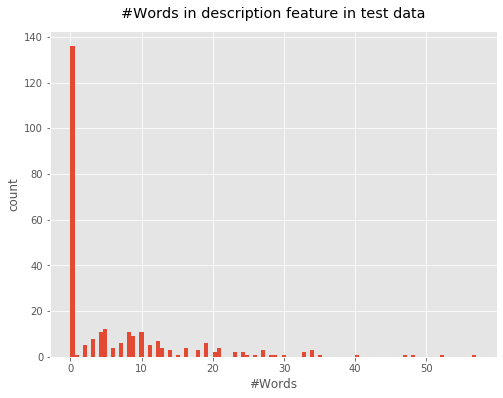

In [20]:
fig = plt.figure(figsize=(8,6))
plt.hist(test['description_length'], bins=100)
plt.xlabel('#Words')
plt.ylabel('count')
plt.title("#Words in description feature in test data", y=1.02);
plt.show()

del test['description_length']

### Distribution of length (no. of words) of the 'name' feature across train and test data

The distribution below depicts how the long the 'name' field is across different item records.<br>

We see that the 'item' field isn't empty (length=0) for any of the records.



In [21]:
train['name_length'] = train['name'].str.split().str.len()
train['name_length'].fillna(0, inplace=True)

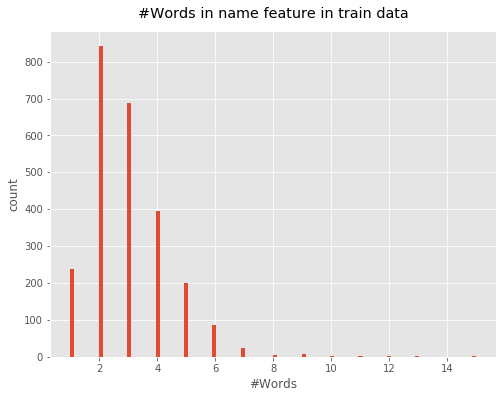

In [22]:
fig = plt.figure(figsize=(8,6))
plt.hist(train['name_length'], bins=100)
plt.xlabel('#Words')
plt.ylabel('count')
plt.title("#Words in name feature in train data", y=1.02);
plt.show()

del train['name_length']

In [23]:
test['name_length'] = test['name'].str.split().str.len()
test['name_length'].fillna(0, inplace=True)

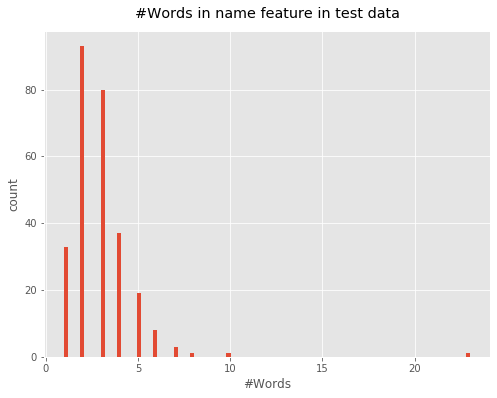

In [24]:
fig = plt.figure(figsize=(8,6))
plt.hist(test['name_length'], bins=100)
plt.xlabel('#Words')
plt.ylabel('count')
plt.title("#Words in name feature in test data", y=1.02);
plt.show()

del test['name_length']

## 2) Data Cleaning

### Text pre-processing

The below section cleans-up the raw text-based fields like 'category', 'name' and 'description' by performing various steps like converting the text to lowercase, removing numbers, punctutations, leading & trailing spaces, stopwords (eg: prepositions, pronouns, conjunctions etc) and finally reducing the inflectional forms of words to a common-base form using lexical knowledge (eg: the word 'appetizers' is reduced to 'appetizer'). It happens quite often that multiple forms of the same word are not really that important and we only need to know the base form of that word.<br>

All the above steps are taken in order to normalize the text features and reduce noise during modeling phase.

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    
    #Convert to lowercase
    text = str(text).lower()
    
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    
    #Remove 'nan' string value
    text = re.sub(r'nan', '', text)
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove leading and ending whitepspaces
    text = text.strip()
    
    #Remove stopwords
    tokens = word_tokenize(text)
    text = [i for i in tokens if not i in stop_words]
    
    #Reducing inflectional forms of words to a common-base form using lexical knowledge (Lemmatization)
    text = ' '.join([lemmatizer.lemmatize(i) for i in text])

    return text

### Combining text-based feature columns

In the data exploration stage, it was observed that though a lot items had description field populated but there
were also some which did not. In such scenario, having other information from fields like 'item' and 'category'
will help the model to make a better prediction instead of blank 'description' value.<br>

Below section itegrates the text features in a single column.

In [26]:
def clean_and_combine(df, columns):
    df['combined_cleaned'] = ''
    for col in columns:
        df[col + '_cleaned'] = df[col].map(clean_text)
        df['combined_cleaned'] = df['combined_cleaned'] + ' '+ df[col + '_cleaned'].astype(str)
    return df

In [27]:
train = clean_and_combine(train, ['name', 'description', 'category'])

In [28]:
train.head()

,name,description,price,menu_section_name,category,is_entree,combined_cleaned,name_cleaned,description_cleaned,category_cleaned
0,Grande Caesar Salad,NaN,9.95,Salad,Salad,0,grande caesar salad salad,grande caesar salad,,salad
1,Medium 16 oz. Green Mayo Smoothie,NaN,4.75,Smoothies,Smoothies,0,medium oz green mayo smoothie smoothy,medium oz green mayo smoothie,,smoothy
2,Iced Tea,"Brewed fresh daily, our Iced Tea pairs seamles...",0.00,Beverages,Beverages,0,iced tea brewed fresh daily iced tea pair sea...,iced tea,brewed fresh daily iced tea pair seamlessly ma...,beverage
3,Specialty Pretzel,Jalapeno cheese and Dutch almond.,3.75,A la Carte,A la Carte,0,specialty pretzel jalapeno cheese dutch almon...,specialty pretzel,jalapeno cheese dutch almond,la carte
4,Broccoli Bites with Cheese,Twelve pieces.,5.99,Side Orders,Side Orders,0,broccoli bite cheese twelve piece side order,broccoli bite cheese,twelve piece,side order


### Why 'menu_section_name' not being considered?

Another thing worth mentioning is that it seems like the fields 'category' and 'menu_section_name' have same values
for majority of records (99.64%). Hence, will be using only one of these fields in our downstream feature creation and modeling task

In [29]:
round(100.0* len(train[train['menu_section_name']==train['category']])/train.shape[0], 2)

99.64

## 3) Feature Extraction

Now that we have explored and preprocessed our data, the next piece in the puzzle is how does one convert these clean text into numerical values because ultimately that's what the machines are adept at dealing and working with.<br>

The idea is to create a representation of individual words in a sentence that capture their meanings, semantic relationships and the different types of contexts they are used in. That’s what word embeddings are – the numerical representation of a text. <br>

Now these word embeddings could either be pre-trained (Pretrained embeddings are trained on large datasets, saved, and then used for solving other tasks. That’s why pretrained word embeddings are a form of Transfer Learning) or learned from scratch for a given task.<br>

**Why do we need Pre-Trained Embeddings?**<br>
Pretrained embeddings capture the semantic and syntactic meaning of a word as they are trained on large datasets. They are capable of boosting the performance of a Natural Language Processing (NLP) model. <br>

Learning embeddings from scratch is a challenging problem due to two primary reasons:<br>

**1) Sparsity of training data:**<br>
Our training data has only ~2500 total records and has a limited vocabularly of words. Arrivng at the right representation of the word by learning the embeddings directly from scratch is hard.<br>

**2) Large number of trainable parameters:**<br>
The overall number of model parameters increase while learning the embeddings from scratch which results in a slower model training process. <br>

**Types of pre-trained embeddings**
There are broadly two types of pre-trained embeddings:<br>

**1) Word-level Embeddings:**<br>
Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing before or after another. To put it another way, words of the same context usually appear together in the corpus, so they will be close in the vector space as well. Eg: Word2Vec (trained on the Google News dataset which has about 100 billion words), GloVe (trained on aggregated global word-word co-occurrence statistics from corpus such as wikipedia, commomn crawl, twitter) <br>

**2) Character-level Embeddings:**<br>
Character level embedding uses one-dimensional convolutional neural network (1D-CNN) to find numeric representation of words by looking at their character-level compositions. <br>

You can think of 1D-CNN as a process where we have several scanners sliding through a word, character by character. These scanners can focus on several characters at a time. As these scanners sweep along, they extract the information from the characters they are focusing on. At the end of these scanning process, information from different scanners are collected to form the representation of a word.<br>

ELMo and Flair embeddings are examples of Character-level embeddings.<br>

**When to use Character-level Embeddings?**<br>
1) To handle an out-of-vocabulary (OOV) word:<br>

The pretrained GloVe “dictionary” is huge and contains millions of words; however, there will come a time where we encounter a word in our training set that is not present in GloVe’s vocabulary. Such a word is called an out-of-vocabulary (OOV) word. GloVe deals with these OOV words by simply assigning them some random vector values. If not remedied, this random assignment would end up confusing our model.<br>

For the purpose of this project, it is **assumed** that majority of the words in the training data will be part of GloVe dictionary.<br>

**Why using GloVe over Word2Vec?**<br>
Word2vec relies only on local information of language. That is, the semantics learnt for a given word, is only affected by the surrounding words. Whereas,  GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors.



In [30]:
# Function to split the data into training and test sets.
def split_dataframe(df, holdout_fraction):
    """Splits a DataFrame into training and validation sets.
    Args:
     df: a dataframe.
     holdout_fraction: fraction of dataframe rows to use in the validation set.
    Returns:
     train: dataframe for training
     validation: dataframe for validating
    """
    validation = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(validation.index)]
    return train, validation

# Split the train data into train (70%) and validation set (30%)
train_df, validation_df = split_dataframe(train, 0.3)

# Create a Tokenizer object
tokenizer = Tokenizer()

# maxlen parameter to specify how long  sequences should be.Setting this to be max length of 'combined_cleaned' feature.
maxlen = max(train['combined_cleaned'].str.split().str.len())

def prepare_train_validation_data(train_df, validation_df):
    
    # Separate-out the predictors and target label to be later used in downstream modeling task
    x_train, y_train = train_df['combined_cleaned'].values, train_df['is_entree'].values
    x_validation, y_validation = validation_df['combined_cleaned'].values, validation_df['is_entree'].values

    # Prepare vocabulary by fitting the tokenizer on train data
    tokenizer.fit_on_texts(list(x_train))

    # saving the tokenizer object
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # store the vocabulary size
    vocab_size = len(tokenizer.word_index) + 1
    
    # convert text into integer sequences 
    x_train = convert_text_to_sequence(x_train, tokenizer, maxlen)
    x_validation = convert_text_to_sequence(x_validation, tokenizer, maxlen)
    
    return x_train, y_train, x_validation, y_validation, vocab_size

# convert text into integer sequences and add padding
def convert_text_to_sequence(df, tokenizer, maxlen):
    """ Convert texts into integer sequences.
    """
    df = tokenizer.texts_to_sequences(df)
    # add padding to prepare sequences of same length
    df = pad_sequences(df, maxlen=maxlen)
    return df

x_train, y_train, x_validation, y_validation, vocab_size = prepare_train_validation_data(train_df, validation_df)

In [31]:
def scale_numeric_values(train_df, validation_df, numeric_features):
    """ Applies min-max scaling to 'price' feature and save the scaler object
    """
    scaler = MinMaxScaler()
    train_df = scaler.fit_transform(train_df[numeric_features])
    
    # saving the scaler object
    with open('scaler.pickle', 'wb') as handle:
        pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

    validation_df = scaler.transform(validation_df[numeric_features])
    return (np.array(train_df), np.array(validation_df))

x_train_numeric, x_validation_numeric = scale_numeric_values(train_df, validation_df, ['price'])

In [32]:
def create_embedding_matrix(filepath, word_tokens, embedding_dim):
    """Creates embedding matrix on the train data vocabulary using the Pre-trained GloVe Embeddings.
    Args:
     filepath: Path for glove embedding file.
     word_tokens: Dictionary of word tokens and index.
     embedding_dim: DImension of the embedding vector.
    Returns:
     embedding_matrix: Numpy matrix containing containing word embedding vectors.
    """
    # We don’t need all words, and can focus on only the words that we have in training data vocabulary. 
    vocab_size = len(word_tokens) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    #load the GloVe embeddings and create an embedding matrix using it
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_tokens:
                idx = word_tokens[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[: embedding_dim]

    return embedding_matrix

In [33]:
embedding_file_path = '/Users/sshaleen/glove/glove.6B.300d.txt'
embedding_dimension = 300
embedding_matrix = create_embedding_matrix(embedding_file_path, tokenizer.word_index, embedding_dimension)
## Note: When we use pretrained word embeddings we have the choice to either allow the embedding to be updated 
## during training or only use the resulting embedding vectors as they are.

## 4) Model Selection and development


**Model Selection** <br>

- In terms of choosing the machine learning model for this natural-language processing task involving large data dimensionality, **deep neural network- based techniques (CNNs, RNNs etc.) are a more natural fit since they provide benefits in learning multiple levels of representation of natural language compared to traditional ML classification models (Logistic Regression, Decision Trees, Ensemble techniques etc.)**<br>


- With regards to which Deep Neural Network type performs better when dealing with text data depends on how often the comprehension of global/long-range semantics is required. RNNs usually are good at predicting what comes next in a sequence (eg: Question Answering, Language Translation etc.). While CNNs are good in classifing a sentence or a paragraph (eg: Sentiment Analysis, Spam Detection or Topic Categorization) which don’t actually need to use the information stored in the sequential nature of the data. <br>


- **CNN** is a class of deep, feed-forward artificial neural networks where connections between nodes do not form a cycle. CNNs are generally used in computer vision, however they’ve shown promising results when applied to various NLP tasks as well. <br>


- **RNN** is a class of artificial neural network where connections between nodes form a directed graph along a sequence. It is basically a sequence of neural network blocks that are linked to each other like a chain. Each one is passing a message to a successor.<br>


**Mode Development**<br>

- For the model developement purposes, Keras library is used. Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras. <br>

- **How does CNN work though specifically in NLP task?** <br>

A CNN has hidden layers which are called convolutional layers. With each convolutional layer the network is able to detect more complex patterns. The convolutional layer consists of multiple filters which are slid across the text sequence and are able to detect specific patterns. When working with sequential data, like text, we work with one dimensional convolutions. The one dimensional convnet (convolutions) is invariant to translations, which means that certain sequences can be recognized at a different position. This can be helpful for certain patterns in the text.


- In the subsequent sections, 4 types of models are built using the Keras Sequential API<br>

**1) Model 1:** This is a **multi-input model which uses both price and text features**. Price feature is fed to a simple Multi-Layered Perceptron architecture whereas Text features are fed to a CNN-based architecture. Eventually both the architectures are concatenated to give out final classification probability. Furthermore, the word embeddings for the text-based features are **trained more scratch** thus increasing the overall model parameters.<br>

**2) Model 2:** This is again a **multi-input model which uses both price and text features**. Price feature is fed to a simple Multi-Layered Perceptron architecture whereas Text features are fed to a CNN-based architecture. Eventiually both the architectures are concatenated to give out final classification probability. But this time the word embeddings for the text-based features are **reused from the GloVe word-embeddings**<br>


**3) Model 3:** This is a **single-input model which uses just the text features**. Text features are fed to a CNN-based architecture. The word embeddings for the text-based features are **reused from the GloVe word-embeddings**<br>


**4) Model 4:** This is a **single-input model which uses just the text features**. Text features are fed to a CNN-based architecture. The word embeddings for the text-based features are **trained from scratch**.<br>








In [34]:
def design_cnn_architecture(embedding_matrix, use_embedding_matrix):
    """Builds the architecture for CNN-based deep neural network for text-based features.
    Args:
     embedding_matrix: Numpy matrix containing containing word embedding vectors.
     
     use_embedding_matrix: Boolean flag. True Value means weights of the embedding layer will be initialized with 
     use_embedding_matrix matrix. False Value means embeddings will be learned from scratch and the weights of the 
     embedding layer are initialized with random weights and are then adjusted through backpropagation during training
    
    Returns:
     model: Returns the CNN based model object with defined architecture
    """
    
    # The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras
    model = Sequential()
    
    if use_embedding_matrix:
        # Model 1: The weights of the embedding layer are initialized with embedding matrix built previously
        model.add(layers.Embedding(vocab_size, embedding_dimension, weights=[embedding_matrix],
                                   input_length=maxlen, trainable=False))
    else:
        # Model 2: The embeddings are learned from scratch and the weights of the embedding layer are initialized 
        # with random weights and are then adjusted through backpropagation during training. 
        model.add(layers.Embedding(vocab_size, embedding_dimension, input_length=maxlen, trainable=True))

    # Parameters of Conv1D: number of filters, the kernel size, and the activation function
    model.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
    
    # Pooling layer acts as a way to downsample the incoming feature vectors
    model.add(layers.GlobalMaxPooling1D())

    # The Dense layer is the regular densely connected neural network layer with all the weights and biases
    model.add(layers.Dense(10, activation='relu'))
    
    return model
    
def compile_model(model, text_only=False):
    """Compiles the model by passing in the optimizer, loss and metrics values.
    Args:
     model: Model object with a defined architecture.
     text_only: Boolean flag. True indicates text-based model
    
    Returns:
     model: Returns compiled model object
    """
    # sigmoid function (final probability output b/w 0 and 1) for the final output layer.
    if text_only:
        model.add(layers.Dense(1, activation='sigmoid'))
    
    # 'Adam' is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
    # procedure to update network weights iteratively based on training data. Empirical results demonstrate that Adam 
    # works well in practice and compares favorably to other stochastic optimization methods.
    # On one hand Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates 
    # and the learning rate does not change during training. Whereas, Adam method computes individual adaptive 
    # learning rates for different parameters 
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    print('model summary: ', model.summary())
    return model

## Below function builds the model using only the 'text' features
def build_text_only_model(embedding_matrix=None, use_embedding_matrix=False):
    """ Builds the CNN-based model architecture for text-only features
    Args:
     embedding_matrix: Numpy matrix containing containing word embedding vectors.
     
     use_embedding_matrix: Boolean flag. True Value means weights of the embedding layer will be initialized with 
     use_embedding_matrix matrix. False Value means embeddings will be learned from scratch and the weights of the 
     embedding layer are initialized with random weights and are then adjusted through backpropagation during training
    
    Returns:
     model: Fully designed and compiled CNN-based model
    """
    model = design_cnn_architecture(embedding_matrix, use_embedding_matrix)
    model = compile_model(model, text_only=True)
    return model

In [35]:
## 2-layered feed-forward multi-layered perceptron model for price feature
def design_mlp_architecture(price_dim):
    """ Builds the architecture for feedforward multi-layered perceptron (MLP) model for price numeric feature.
    
    Args:
     price_dim: Dimension of the 'price' feature i.e. 1
    
    Returns:
     model: Returns the MLP based model object with defined architecture
    """
    model = Sequential()
    model.add(layers.Dense(10, input_dim=price_dim, activation="relu"))
    model.add(layers.Dense(5, activation="relu"))
    return model

def build_text_plus_price_model(embedding_matrix=None, use_embedding_matrix=False, price_dim=None):
    """Concatenates the CNN and MLP based model objects and compiles the final model.
    
    Args:
     embedding_matrix: Numpy matrix containing containing word embedding vectors.
     
     use_embedding_matrix: Boolean flag. True Value means weights of the embedding layer will be initialized with 
     use_embedding_matrix matrix. False Value means embeddings will be learned from scratch and the weights of the 
     embedding layer are initialized with random weights and are then adjusted through backpropagation during training
    
     price_dim: Dimension of the 'price' feature i.e. 1
     
    Returns:
     model: Fully designed, integrated and compiled MLP plus CNN-based model
    """
    model_text = design_cnn_architecture(embedding_matrix, use_embedding_matrix)
    model_price = design_mlp_architecture(price_dim)
    
    # create the input to our final set of layers as the *output* of both the MLP and CNN
    combinedInput = concatenate([model_price.output, model_text.output])
    # Final layer head will have two dense layers
    x = layers.Dense(10, activation="relu")(combinedInput)
    x = layers.Dense(1, activation="sigmoid")(x)
    
    # Final model will accept 'price' data on the MLP (Price) input and text on the CNN input, outputting single 
    # value (is_entree= 0 or 1)
    model = tf.keras.Model(inputs=[model_price.input, model_text.input], outputs=x)
    model = compile_model(model)
    return model

In [36]:
## The below function 'fits' the model on the training data and then evaluates it on the validation data
def fit_evaluate_model(model, model_name, x_train, y_train, x_validation, y_validation):
    """ Fits the model on the training data and then evaluates it on the validation data
    """
    
    start = time.time()
    history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_validation, y_validation),
                    batch_size=10)
    print('model training time for {}: {:.4f}'.format(model_name, (time.time() - start)))
    print('\n')
    loss, accuracy, auc, precision, recall = model.evaluate(x_train, y_train, verbose=False)
    print("Training Accuracy for {}: {:.4f}".format(model_name, accuracy))
    print("Training AUC for {}: {:.4f}".format(model_name, auc))
    print("Training precision for {}: {:.4f}".format(model_name, precision))
    print("Training recall for {}: {:.4f}".format(model_name, recall))

    loss, accuracy, auc, precision, recall  = model.evaluate(x_validation, y_validation, verbose=False)
    print('\n')
    print("Validation Accuracy for {}:  {:.4f}".format(model_name, accuracy))
    print("Validation AUC for {}: {:.4f}".format(model_name, auc))
    print("Validation precision for {}: {:.4f}".format(model_name, precision))
    print("Validation recall for {}: {:.4f}".format(model_name, recall))
    return model, history


In [37]:
## Model 1: Build and train model using both text and price features and training the embeddings from scratch
clear_session()
model_name = 'text_price_embeddings_scratch'

text_price_embeddings_scratch = build_text_plus_price_model(price_dim=x_train_numeric.shape[1])

text_price_embeddings_scratch, history_text_price_embeddings_scratch = fit_evaluate_model(
    text_price_embeddings_scratch, model_name,
    [x_train_numeric, x_train],
    y_train, [x_validation_numeric, x_validation],
    y_validation)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 63)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 63, 300)      622500      embedding_input[0][0]            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 128)      192128      embedding[0][0]                  
______________________________________________________________________________________________

In [38]:
## Model 2: Build and train model using both text and price features and reusing the GloVe word-embeddings
clear_session()
model_name = 'text_price_embeddings_glove'

text_price_embeddings_glove= build_text_plus_price_model(
    embedding_matrix=embedding_matrix,
    use_embedding_matrix=True,
    price_dim=x_train_numeric.shape[1])

text_price_embeddings_glove, history_text_price_embeddings_glove = fit_evaluate_model(
    text_price_embeddings_glove, model_name,
    [x_train_numeric, x_train],
    y_train, [x_validation_numeric, x_validation],
    y_validation)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 63)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 63, 300)      622500      embedding_input[0][0]            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 128)      192128      embedding[0][0]                  
______________________________________________________________________________________________

In [39]:
## Model 3: Build and train model using just text features and reusing the GloVe word-embeddings
clear_session()
model_name = 'text_only_embeddings_glove'

text_only_embeddings_glove= build_text_only_model(
    embedding_matrix=embedding_matrix,
    use_embedding_matrix=True)

text_only_embeddings_glove, history_text_only_embeddings_glove = fit_evaluate_model(
    text_only_embeddings_glove, model_name,
    x_train,
    y_train, x_validation,
    y_validation)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 63, 300)           622500    
_________________________________________________________________
conv1d (Conv1D)              (None, 63, 128)           192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 815,929
Trainable params: 193,429
Non-trainable params: 622,500
_________________________________________________________________
model summary:  None
model training time for text_only_embeddings_glove: 14.6668


Training Accuracy for text_

In [40]:
## Model 4: Build and train model using just text features and training the word-embeddings from scratch.
## The embeddings are learned from scratch and the weights of the embedding layer are initialized 
# with random weights and are then adjusted through backpropagation during training.

clear_session()
model_name = 'text_only_embeddings_scratch'

text_only_embeddings_scratch= build_text_only_model()

text_only_embeddings_scratch, history_text_only_embeddings_scratch = fit_evaluate_model(
    text_only_embeddings_scratch, model_name,
    x_train,
    y_train, x_validation,
    y_validation)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 63, 300)           622500    
_________________________________________________________________
conv1d (Conv1D)              (None, 63, 128)           192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 815,929
Trainable params: 815,929
Non-trainable params: 0
_________________________________________________________________
model summary:  None
model training time for text_only_embeddings_scratch: 20.5736


Training Accuracy for text_only

## 5) Choice of Metrics for Model Evaluation

There are metrics on which one can evaluate a classification model. But there are few which are more robust and dependable when the data is less balanced (eg: in our dataset, is_entree=1 accounts for only ~8% in the overall training data) and is more skewed in favor of one class over another. These metrics include:<br>

1) **Precision:** Precision identifies the frequency with which a model was correct when predicting the positive class i.e (True Positives) / (True Positives + False Positive)<br>

2) **Recall:** It tells out of all the possible positive labels, how many did the model correctly identify i.e (True Positives) / (True Positives + False Negatives)<br>

3) **F1 Score:** F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.<br>

4) **AUC (Area Under the ROC Curve):** It considers all possible classification thresholds and is the probability that a classifier will be more confident that a randomly chosen positive example is actually positive than that a randomly chosen negative example is positive.<br>


**Why we should refrain from using accuracy as the evaluation metric when working with imbalanced datasets?**<br>
The main reason is since accuracy does not distinguish between the numbers of correctly classified examples of different classes in-case of imbalanced data. Eg: A model that predicts the majority class (is_entree=0) for all examples in the test set will have a classification accuracy of ~96% percent leading to a recall value of 0. <br>


In [41]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    auc = history.history['AUC']
    val_auc = history.history['val_AUC']
    
    precision = history.history['Precision']
    val_precision = history.history['val_Precision']
    
    recall = history.history['Recall']
    val_recall = history.history['val_Recall']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(20, 10))
    
    plt.subplot(3, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(x, auc, 'b', label='Training AUC')
    plt.plot(x, val_auc, 'r', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.legend()
    
    plt.subplot(3, 2, 4)
    plt.plot(x, precision, 'b', label='Training Precision')
    plt.plot(x, val_precision, 'r', label='Validation Precision')
    plt.title('Training and validation Precision')
    plt.legend()
    
    plt.subplot(3, 2, 5)
    plt.plot(x, recall, 'b', label='Training Recall')
    plt.plot(x, val_recall, 'r', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.legend()

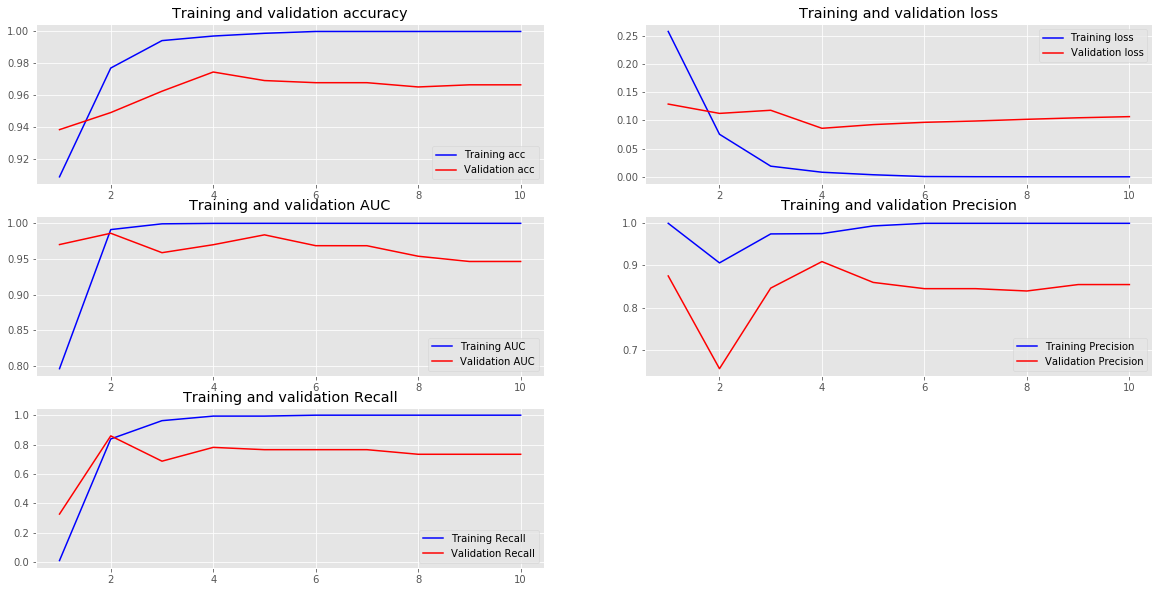

In [42]:
plot_history(history_text_price_embeddings_scratch)

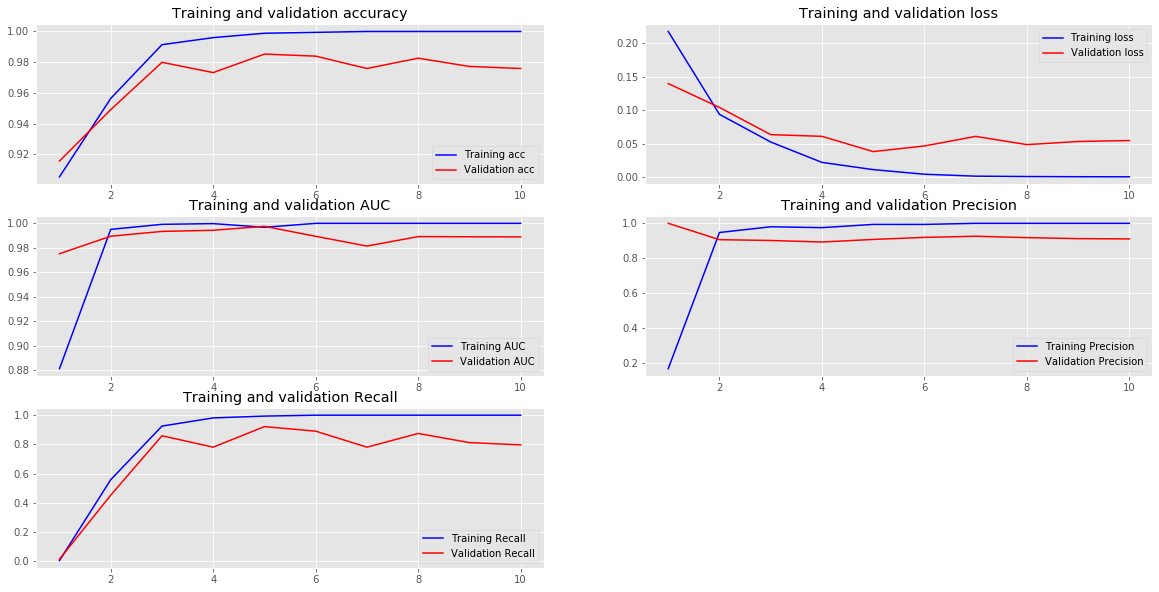

In [43]:
plot_history(history_text_price_embeddings_glove)

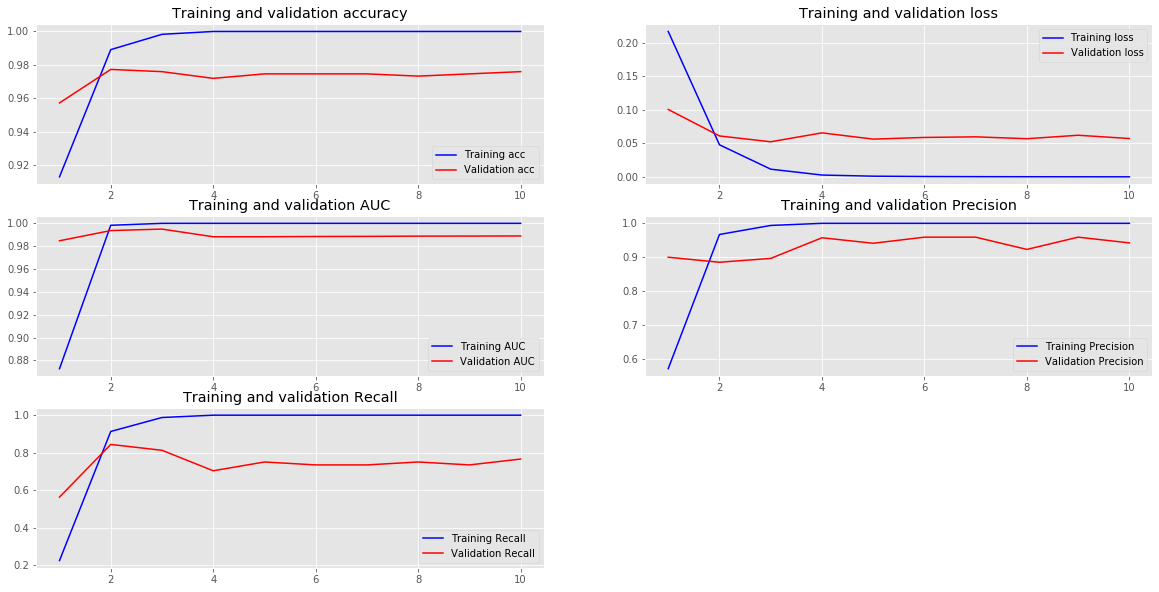

In [44]:
plot_history(history_text_only_embeddings_glove)

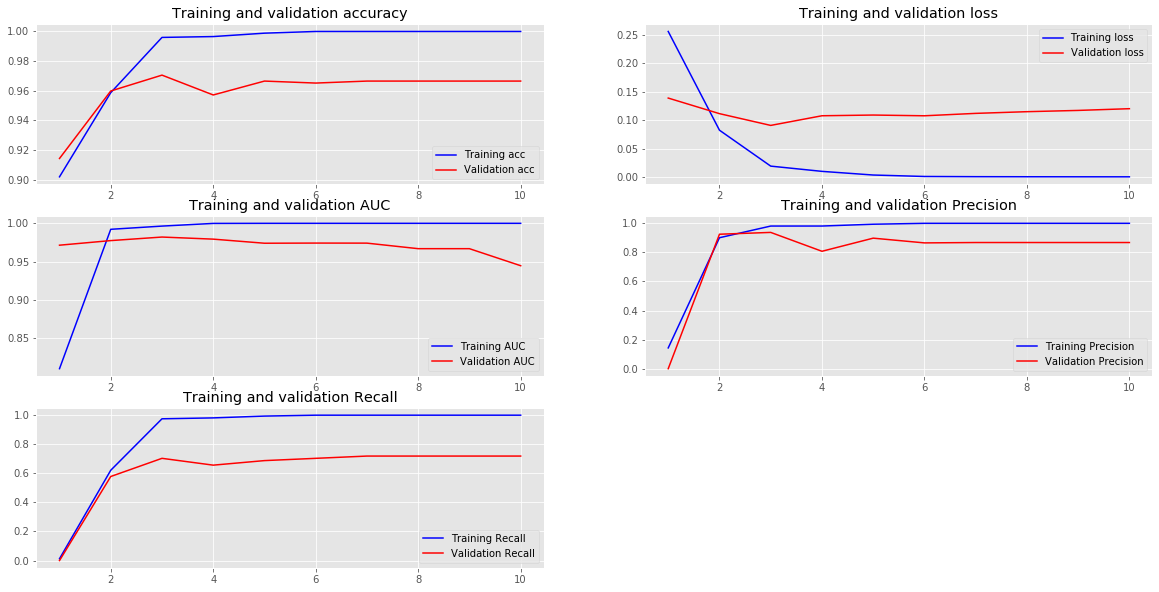

In [45]:
plot_history(history_text_only_embeddings_scratch)

## 6) Model Prediction and Key Takeaways

Here, we first preprocess the test data, applying the same procedures which were earlier applied to train and validation dataset.<br>

From the model training exercise above, it was observed that both 'model 2' (uses price and text features using pre-trained GloVe word-emdeddings)and 'model 3' (uses just the text features using pre-trained GloVe embeddings) seem to be performing well compared 'Model 1' and Model 4 on validation set.<br>

**Key Takeaways**<br>
1) 'model 2' seems to be performing fairly well on the test data across key metrics like Precision, Recall, F1-Score and AUC:<br>
**Precision: 0.93**<br>
**Recall: 0.96**<br>
**f1-score: 0.94**<br>
**AUC-Score: 0.99**<br>

2) Out of the total 276 predictions (test data size) made by the model, there were only 2 False-Positives and 1 False-Negatives which shows that 'model 2' is performing pretty well with a **98.9% accuracy** (test data orginally has 95.3% records with is_entree=0)<br>

In [46]:
def clean_process_test_data(test, price=False):
    """ Processes and cleans the test data by applying the same transformations as were applied to Train data
    """
    
    test = clean_and_combine(test, ['name', 'description', 'category'])
    
    # load the saved Tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    # Tokenize the text
    x_test = convert_text_to_sequence(test['combined_cleaned'].values, tokenizer, maxlen)
    
    if price:
        with open('scaler.pickle', 'rb') as handle:
            scaler = pickle.load(handle)
        x_test_price = scaler.transform(test[['price']])
        return [np.array(x_test_price), x_test]
    return x_test

### Prediction on Test data using 'Model 2'

In [47]:
# Setting the classification threshold to be 0.5
threshold = 0.5

predicted_probabilities = [prediction[0] for prediction in text_price_embeddings_glove.predict(
    clean_process_test_data(test, True))]
test['is_entree_predicted'] = [1 if p >= threshold else 0 for p in predicted_probabilities]


In [48]:
## computes the precision, recall, f1-score metric
print(classification_report(test['is_entree'].values,
                            test['is_entree_predicted'],
                            target_names=['is_entree = 0', 'is_entree = 1']))

               precision    recall  f1-score   support

is_entree = 0       1.00      0.99      0.99       263
is_entree = 1       0.86      0.92      0.89        13

     accuracy                           0.99       276
    macro avg       0.93      0.96      0.94       276
 weighted avg       0.99      0.99      0.99       276



In [49]:
## Computes AUC score
print('AUC Score:', roc_auc_score(test['is_entree'].values, predicted_probabilities))

AUC Score: 0.9915179877157063


In [50]:
## Computes Confusion-Matrix to undertstand the mis-classifications made by the model
pd.crosstab(test['is_entree'].values, test['is_entree_predicted'].values ,
            rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,261,2,263
1,1,12,13
All,262,14,276


In [52]:
## write out the predictions to a file
test.to_csv('test_results.csv')

## 7) Other methods/techniques that could be implemented

Currently, we are working with a limited size of data ~2500 records where a not-so-complex CNN-based model seem to perform decently well across train, validation and test set. But with more data, we can further explore additional techniques to further improve model's performance. Some of the techniques that can be further tried include:<br>

**1) Hyperparameter Optimization**<br>
One of the crucial steps of deep learning and working with neural networks is hyperparameter optimization. As we see in the models that were used above, there are a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning.
Some of the common methods for hyperparameter optimization include:<br>

**a) Grid-Search:** This method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. **It is the most thorough way but also the most computationally heavy way to do this.**<br>

**b) Random-Search:** This method  takes random combinations of parameters. The RandomizedSearchCV Class implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets.<br>

**2) BiDirectional LSTM**<br>
Although, conventional CNN-based models do well on text-classification tasks by taking care of words in close ranges but it still lacks the ability to capture all the context provided in a particular text sequence. BiDirectional LSTM (Long Short-Term Memory, a sub-class of RNN) keeps the contextual information in both directions which is pretty useful in text classification task. Due to the limitations of traditional RNNs like not remembering long term dependencies, in practice, we almost always use LSTM/GRU to model long term dependencies.

**3) Attention Models**<br>
In the past, conventional methods like TFIDF(Term-Frequency Inverse Document Frequency)/CountVectorizer etc. we used to find features from the text by doing a keyword extraction. Some word is more helpful in determining the category of a text than others.<br> 
However, in this method we sort of lost the sequential structure of the text. With LSTM and deep learning methods, while we can take care of the sequence structure, we lose the ability to give higher weight to more important words.<br> 'Attention Models' help in providing the best of both the worlds. Attention mechanism extracts such words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector.<br>

**4) Transformer-based methods (eg: BERT)**<br>
One of the challenges with LSTM/GRU with Attention type of models is that they are recurrent in nature and the runtime increases as the sequence length increases. These architectures take a sentence and process each word in a sequential way, and hence with the increase in sentence length the whole runtime increases.<br>
Transformer-based model architecture lets go of this recurrence and instead relies entirely on an attention mechanism to draw global dependencies between input and output which makes it fast as well.<br>


## 8) Additional Information that would have been useful

1) Images corresponding to these food items could be a useful feature that could provided additional information to the model to learn the underlying patterns.<br>
2) Currently, the dataset is of limited size. Increasing the data size (with diverse variety of records) will further help the model to generalize better.